In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.decomposition import PCA
from torch import nn,Tensor,stack,int64, float64, argmax
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from sklearn.metrics import accuracy_score, precision_score, f1_score
import warnings

In [5]:
"""========ACC analysis========="""

with open("./WESAD/train/S2/S2.pkl", "rb") as f:
    file = pickle.load(f,encoding="latin1")
    print( file["signal"]["chest"].keys())
    df=pd.DataFrame(file['signal']['chest']["ACC"])
    print(df)

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
              0       1       2
0        0.9554 -0.2220 -0.5580
1        0.9258 -0.2216 -0.5538
2        0.9082 -0.2196 -0.5392
3        0.8974 -0.2102 -0.5122
4        0.8882 -0.2036 -0.4824
...         ...     ...     ...
4255295  0.8750 -0.1234 -0.2974
4255296  0.8750 -0.1262 -0.2988
4255297  0.8718 -0.1238 -0.3042
4255298  0.8730 -0.1234 -0.3026
4255299  0.8702 -0.1220 -0.3022

[4255300 rows x 3 columns]


In [3]:
file["signal"]["chest"].keys()

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])

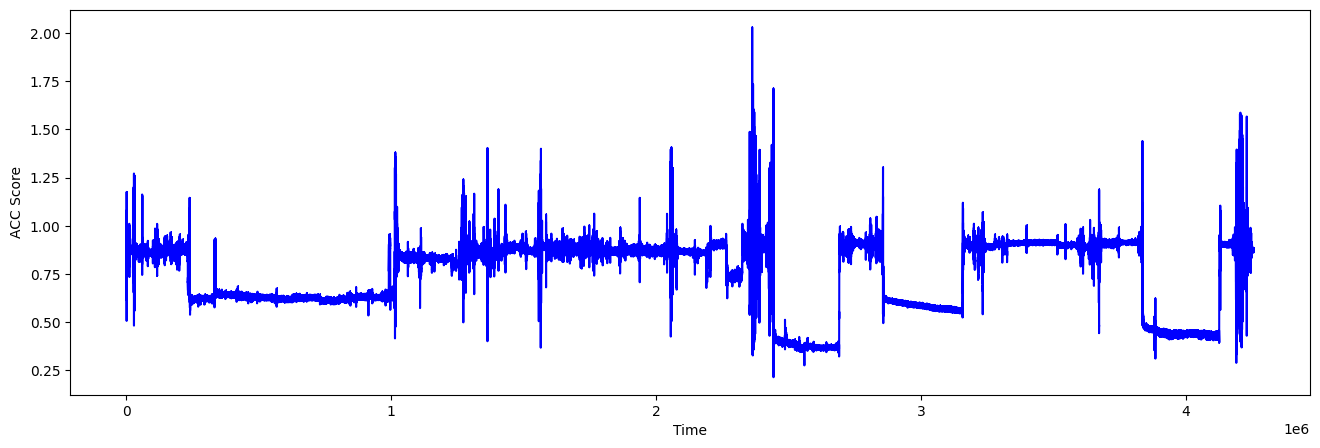

In [6]:
plt.figure(figsize=(16,5))
plt.xlabel("Time")
plt.ylabel("ACC Score")
plt.plot(df.index, df[0], c="b", marker=",")

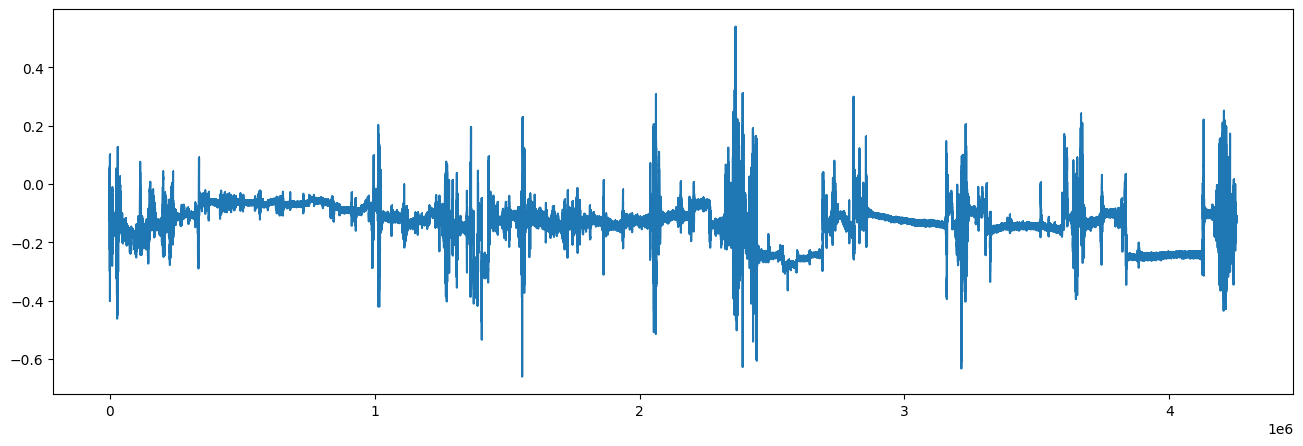

In [6]:
plt.figure(figsize=(16,5))
plt.plot(df.index, df[1], marker=",")

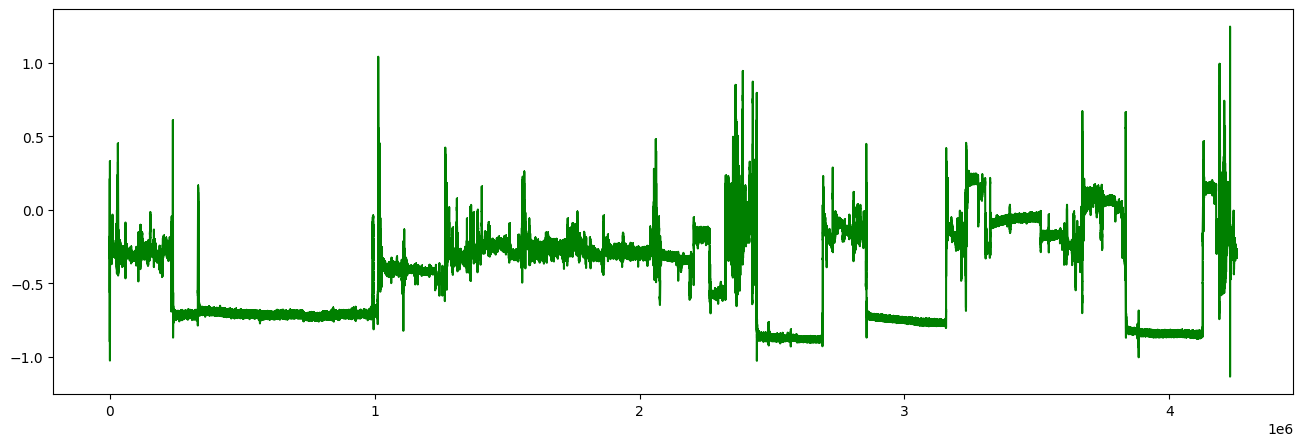

In [7]:
plt.figure(figsize=(16,5))
plt.plot(df.index, df[2], c="g", marker=",")

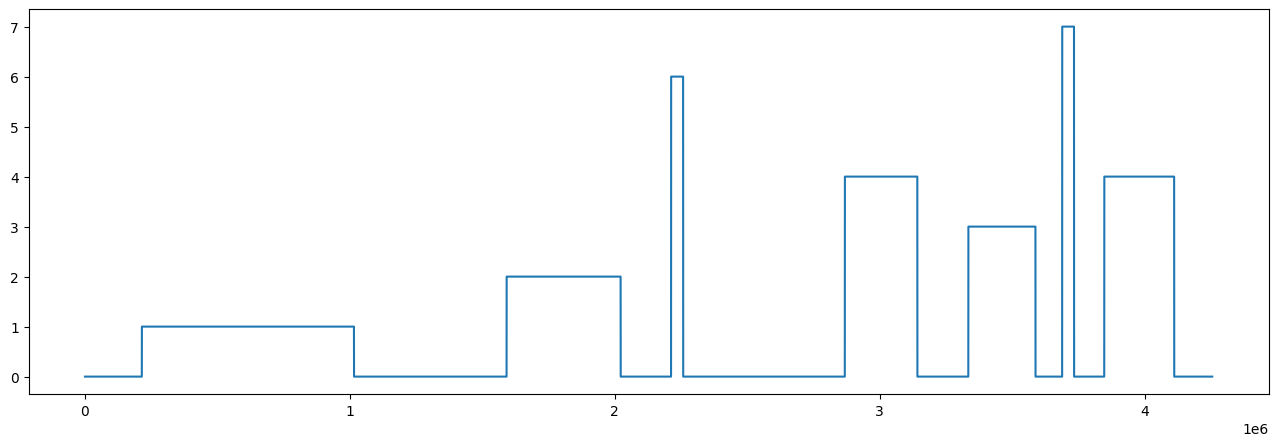

In [8]:
plt.figure(figsize=(16,5))
plt.plot(file["label"])

In [10]:
print("====label mean=====")
Y= np.where(np.array(file["label"])>2, 1.0, 0.0)
print(pd.DataFrame(Y).mean())
y_mean = pd.DataFrame(Y).mean()
y_variation = Y-y_mean[0]
print("====label variation=====")
print(f"variation sum: {sum(y_variation)}")

====label mean=====
0    0.207106
dtype: float64
====label variation=====
variation sum: 1.4005771676817158e-05


In [11]:
print("====ACC1 mean====")
print(f"ACC1 mean: {df[0].mean()}")
acc1_mean = df[0].mean()
acc1_variation= df[0]-acc1_mean
print(f"ACC1 variation sum: {sum(acc1_variation)}")
print("====ACC2 mean====")
print(f"ACC2 mean: {df[1].mean()}")
acc2_mean = df[1].mean()
acc2_variation= df[1]-acc2_mean
print(f"ACC2 variation sum: {sum(acc2_variation)}")
print("====ACC3 mean====")
print(f"ACC3 mean: {df[2].mean()}")
acc3_mean = df[2].mean()
acc3_variation= df[2]-acc3_mean
print(f"ACC3 variation sum: {sum(acc3_variation)}")

====ACC1 mean====
ACC1 mean: 0.7538655511421835
ACC1 variation sum: -4.550618935672546e-06
====ACC2 mean====
ACC2 mean: -0.1331884317841762
ACC2 variation sum: 1.7572041499658297e-07
====ACC3 mean====
ACC3 mean: -0.42268123074315833
ACC3 variation sum: -5.7094816193759e-06


0          0.201534
1          0.171934
2          0.154334
3          0.143534
4          0.134334
             ...   
4255295    0.121134
4255296    0.121134
4255297    0.117934
4255298    0.119134
4255299    0.116334
Name: 0, Length: 4255300, dtype: float64

In [12]:
print("Non-Normalize correlation between Y(stress) and X(ACC[1,2,3])(accelerometer sensor's data)")
acc1_correlation= sum((acc1_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, acc1_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation acc1: {acc1_correlation}")
acc2_correlation= sum((acc2_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, acc2_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation acc2: {acc2_correlation}")
acc3_correlation= sum((acc3_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, acc3_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation acc3: {acc3_correlation}")

Non-Normalize correlation between Y(stress) and X(ACC[1,2,3])(accelerometer sensor's data)
correlation acc1: -0.2473103445347065
correlation acc2: -0.2465101956539955
correlation acc3: -0.16048017822646216


In [14]:
norm_acc1 = df[0]/np.linalg.norm(df[0])
acc1_variation = norm_acc1-norm_acc1.mean()
print("Normalize correlation between Y(stress) and X(ACC[1,2,3])(accelerometer sensor's data)")
acc1_correlation= sum((acc1_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, acc1_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation acc1: {acc1_correlation}")

norm_acc2 = df[1]/np.linalg.norm(df[1])
acc2_variation = norm_acc2-norm_acc2.mean()

acc2_correlation= sum((acc2_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, acc2_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation acc2: {acc2_correlation}")

norm_acc3 = df[2]/np.linalg.norm(df[2])
acc3_variation = norm_acc3-norm_acc3.mean()

acc3_correlation= sum((acc3_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, acc3_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation acc3: {acc3_correlation}")

Normalize correlation between Y(stress) and X(ACC[1,2,3])(accelerometer sensor's data)
correlation acc1: -0.24731034453412737
correlation acc2: -0.24651019565378565
correlation acc3: -0.16048017822655058


In [15]:
pca=PCA(n_components=3)
X=np.stack([norm_acc1.array, norm_acc2.array, norm_acc3.array], axis=0)
Y=np.stack([file["label"]], axis=0)
pca.fit(X,Y)
print(pca.explained_variance_ratio_)
print("90% 이상의 데이터 공선성이 존재한다. 이럴경우 ACC1 외에 2개의 데이터는 드랍시켜도 무방함")

[9.16773730e-01 8.32262696e-02 1.57801265e-28]
90% 이상의 데이터 공선성이 존재한다. 이럴경우 ACC1 외에 2개의 데이터는 드랍시켜도 무방함


In [16]:
"""===========ECG analysis============="""
df=pd.DataFrame(file['signal']['chest']['ECG'])
df

,0
0,0.021423
1,0.020325
2,0.016525
3,0.016708
4,0.011673
...,...
4255295,-0.013138
4255296,-0.010345
4255297,-0.005447
4255298,0.000137


In [17]:
print("====ECG mean====")
print(f"ECG mean: {df[0].mean()}")
norm_ecg = df[0]/np.linalg.norm(df[0])
ecg_mean = df[0].mean()
ecg_variation= df[0]-ecg_mean
print(f"ECG variation sum: {sum(acc1_variation)}")

====ECG mean====
ECG mean: 0.001212244628837402
ECG variation sum: 1.0016189808982612e-12


In [18]:
print("correlation between Y(stress) and X(ECG)")
ecg_correlation= sum((ecg_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, ecg_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation ECG: {ecg_correlation}")

correlation between Y(stress) and X(ECG)
correlation ECG: 6.115837118509061e-05


In [19]:
"""===========EMG analysis============"""
df=pd.DataFrame(file['signal']['chest']['EMG'])
df

,0
0,-0.004440
1,0.004349
2,0.005173
3,0.007187
4,-0.015152
...,...
4255295,0.020370
4255296,0.019592
4255297,-0.017166
4255298,-0.028976


In [20]:
print("====EMG mean====")
print(f"EMG mean: {df[0].mean()}")
norm_emg = df[0]/np.linalg.norm(df[0])
emg_mean = df[0].mean()
emg_variation= df[0]-emg_mean
print(f"EMG variation sum: {sum(emg_variation)}")

====EMG mean====
EMG mean: -0.002412917764868223
EMG variation sum: 1.4228042161112953e-08


In [21]:
print("correlation between Y(stress) and X(EMG)")
emg_correlation= sum((emg_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, emg_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation EMG: {emg_correlation}")

correlation between Y(stress) and X(EMG)
correlation EMG: 0.00557882024645787


In [22]:
"""EDA analysis"""
df=pd.DataFrame(file['signal']['chest']['EDA'])
df

,0
0,5.250549
1,5.267334
2,5.243301
3,5.249405
4,5.286407
...,...
4255295,0.400162
4255296,0.355911
4255297,0.360489
4255298,0.365829


In [23]:
print("====EDA mean====")
print(f"EDA mean: {df[0].mean()}")
norm_eda = df[0]/np.linalg.norm(df[0])
eda_mean = df[0].mean()
eda_variation= df[0]-eda_mean
print(f"EDA variation sum: {sum(eda_variation)}")

====EDA mean====
EDA mean: 1.5283874467075147
EDA variation sum: 0.00018462320083001416


In [24]:
print("correlation between Y(stress) and X(EDA)")
eda_correlation= sum((eda_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, eda_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation EDA: {eda_correlation}")

correlation between Y(stress) and X(EDA)
correlation EDA: -0.31643786356458276


In [25]:
"""Temp analysis"""
df=pd.DataFrame(file['signal']['chest']['Temp'])
df

,0
0,30.120758
1,30.129517
2,30.138214
3,30.129517
4,30.130951
...,...
4255295,31.457733
4255296,31.476898
4255297,31.459229
4255298,31.484283


In [26]:
print("====Temp mean====")
print(f"Temp mean: {df[0].mean()}")
norm_temp = df[0]/np.linalg.norm(df[0])
Temp_mean = df[0].mean()
Temp_variation= df[0]-Temp_mean
print(f"Temp variation sum: {sum(Temp_variation)}")

====Temp mean====
Temp mean: 30.87666893005371
Temp variation sum: 29.23657989501953


In [27]:
print("correlation between Y(stress) and X(Temp)")
Temp_correlation= sum((Temp_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, Temp_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation EDA: {Temp_correlation}")

correlation between Y(stress) and X(Temp)
correlation EDA: 0.3771644111205388


In [28]:
"""Resp analysis"""
df=pd.DataFrame(file['signal']['chest']['Resp'])
df

,0
0,-1.148987
1,-1.124573
2,-1.152039
3,-1.158142
4,-1.161194
...,...
4255295,-1.063538
4255296,-1.106262
4255297,-1.103210
4255298,-1.086426


In [29]:
print("====Resp mean====")
print(f"Resp mean: {df[0].mean()}")
norm_resp = df[0]/np.linalg.norm(df[0])
Resp_mean = df[0].mean()
Resp_variation= df[0]-Resp_mean
print(f"Resp variation sum: {sum(Resp_variation)}")

====Resp mean====
Resp mean: 0.05490613926665258
Resp variation sum: -9.687850566209022e-08


In [30]:
print("correlation between Y(stress) and X(Resp)")
Resp_correlation= sum((Resp_variation)*(y_variation))/math.sqrt(sum(map(lambda x: x**2, Resp_variation))*sum(map(lambda x: x**2, y_variation)))
print(f"correlation Resp: {Resp_correlation}")

correlation between Y(stress) and X(Resp)
correlation Resp: 0.00233865848831604


In [29]:
pd.DataFrame({"Correlation":[acc1_correlation, ecg_correlation, emg_correlation, eda_correlation, Temp_correlation, Resp_correlation]}, index=["ACC","ECG", "EMG","EDA","Temp","Resp"]).to_csv("./correlation.csv")

In [30]:
def f(x):
    lis = [0,0,0,0,0,0,0,0]
    lis[x]=1
    return lis
x_dataset = list(zip(norm_acc1, norm_eda, norm_temp))
y_dataset = list(map(f, file["label"]))
print(len(y_dataset))
train_dataset = list(zip(x_dataset, y_dataset))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)


4255300


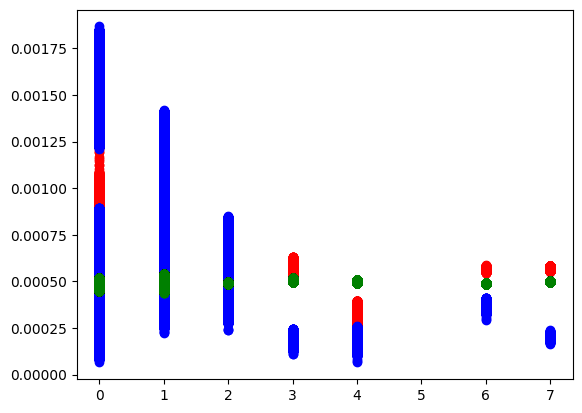

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter( file["label"], norm_acc1,c="r")
ax.scatter( file["label"],norm_eda, c="b")
ax.scatter( file["label"],norm_temp, c="g")

Text(0.5, 0, 'Time')

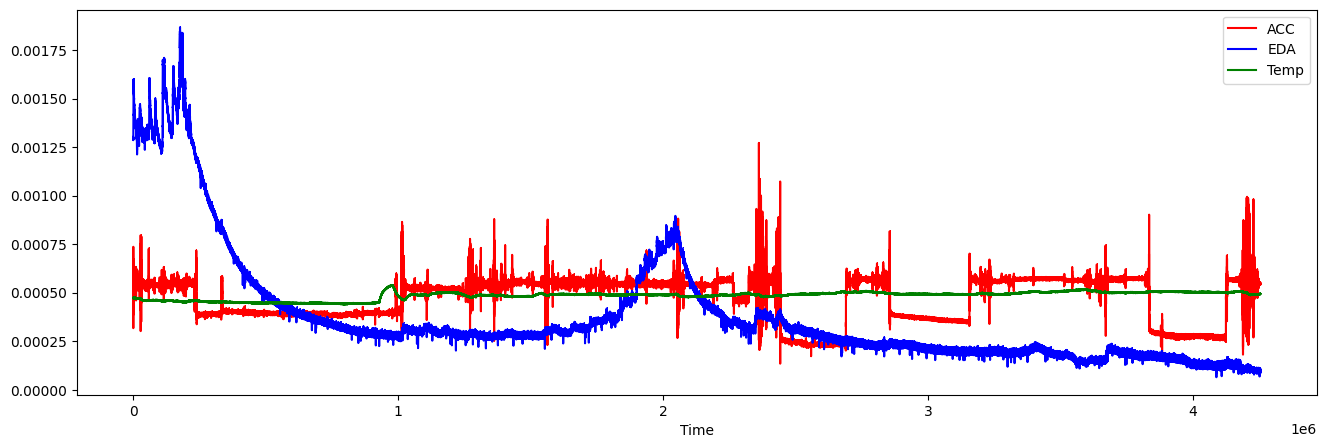

In [32]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot()
ax.plot(range(len(norm_acc1)),norm_acc1,c="r", marker=",", label="ACC")
ax.plot(range(len(norm_eda)),norm_eda, c="b", marker=",", label = "EDA")
ax.plot(range(len(norm_temp)),norm_temp, c="g", marker=",", label = "Temp")
ax.legend()
ax.set_xlabel("Time")

In [33]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(3, 8),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.net(x)

In [34]:
net = Model()
net.double()
lossf = nn.BCEWithLogitsLoss()
optimizer = SGD(net.parameters(), 1e-4)
print(net)

Model(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Softmax(dim=1)
  )
)


In [35]:
def train(net, train_loader, epoch, lossf, optimizer):
    warnings.filterwarnings("ignore")
    net.train()
    for e in range(epoch):
        acc=0
        precision=0
        f1score=0
        for b ,sample in enumerate(train_loader):
            X, Y = sample
            
            X = stack(X, dim=1)
            Y = stack(Y, dim=1)
            
            out = net(X)
            loss = lossf(out, Y.type(float64))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            Y = argmax(Y, dim=1)
            out = argmax(out, dim=1)
            acc+= accuracy_score(Y.detach().numpy(), out.detach().numpy())
            precision+= precision_score(Y.detach().numpy(), out.detach().numpy(), average='macro')
            f1score += f1_score(Y.detach().numpy(), out.detach().numpy(), average="macro")
            
            
        print(f"epoch{e+1}: loss: {loss.item(): .4f} acc: {acc/(b+1): .4f} precision: {precision/(b+1): .4f} f1score {f1score/(b+1): .4f}")

In [36]:
train(net, train_loader, 10, lossf, optimizer)

KeyboardInterrupt: 